In [114]:
import torch
import torchvision

In [115]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

Now we'll also need DataLoaders for the dataset. This is where TorchVision comes into play. It let's use load the MNIST dataset in a handy way. We'll use a batch_size of 64 for training and size 1000 for testing on this dataset. The values 0.1307 and 0.3081 used for the Normalize() transformation below are the global mean and standard deviation of the MNIST dataset, we'll take them as a given here.

TorchVision offers a lot of handy transformations, such as cropping or normalization.

In [116]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [117]:
# Now let's take a look at some examples. We'll use the test_loader for this.
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

# example_targets.shape

torch.Size([1000, 1, 28, 28])

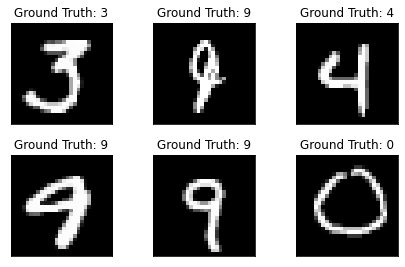

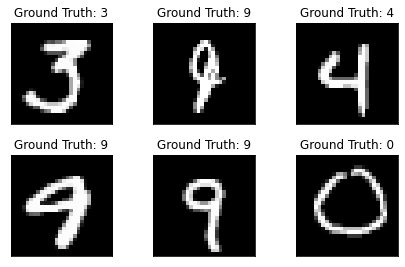

In [118]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

Building the Network

Now let's go ahead and build our network. We'll use two 2-D convolutional layers followed by two fully-connected (or linear) layers. As activation function we'll choose rectified linear units (ReLUs in short) and as a means of regularization we'll use two dropout layers. In PyTorch a nice way to build a network is by creating a new class for the network we wish to build. Let's import a few submodules here for more readable code.

In [119]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [120]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [121]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [122]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

We'll run our test loop once before even starting the training to see what accuracy/loss we achieve just with randomly initialized network parameters. Can you guess what our accuracy might look like for this case?

In [123]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './model.pth')
      torch.save(optimizer.state_dict(), './optimizer.pth')
    
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Neural network modules as well as optimizers have the ability to save and load their internal state using .state_dict(). With this we can continue training from previously saved state dicts if needed - we'd just need to call .load_state_dict(state_dict). 

Now for our test loop. Here we sum up the test loss and keep track of correctly classified digits to compute the accuracy of the network. 

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Using the context manager no_grad() we can avoid storing the computations done producing the output of our network in the computation graph.

Time to run the training! We'll manually add a test() call before we loop over n_epochs to evaluate our model with randomly initialized parameters.

In [124]:
# test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

C:\Users\Sebastain\AppData\Local\Temp\ipykernel_8008\161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.319280
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.290954
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.318535
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.261000
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.259137
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.229576
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.196151
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.181698
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.088444
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.014765
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.818533
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.822772
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.838733
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.530556
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.738141
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.420971
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.369238
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.335397
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.182360
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.056649
Train Epoch: 1 [12800/60000 (

Evaluating the Model's Performance

And that's it. With just 3 epochs of training we already managed to achieve 97% accuracy on the test set! We started out with randomly initialized parameters and as expected only got about 10% accuracy on the test set before starting the training.

Let's plot our training curve.

fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

looks like we could even continue training for a few more epochs!

But before that let's again look at a few examples as we did earlier and compare the model's output.

In [125]:
with torch.no_grad():
  output = network(example_data)

C:\Users\Sebastain\AppData\Local\Temp\ipykernel_8008\161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


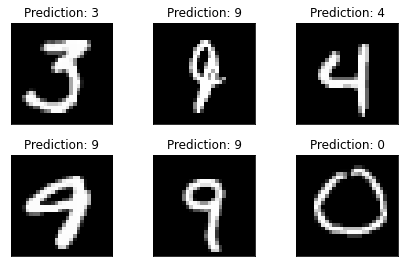

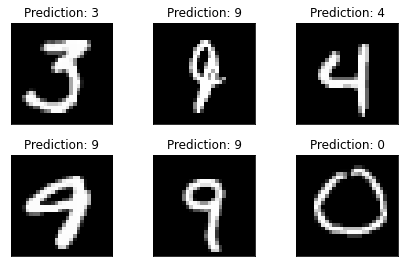

In [126]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

Continued Training from Checkpoints

Now let's continue training the network, or rather see how we can continue training from the state_dicts we saved during our first training run. We'll initialize a new set of network and optimizers.

In [127]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

Using .load_state_dict() we can now load the internal state of the network and optimizer when we last saved them.

In [128]:
network_state_dict = torch.load('model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

Again running a training loop should immediately pick up the training where we left it. To check on that let's simply use the same lists as before to keep track of the loss values. Due to the way we constructed the test counter for the number of training examples seen we manually have to append to it here.

In [129]:
for i in range(11,21):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

C:\Users\Sebastain\AppData\Local\Temp\ipykernel_8008\161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 11 [0/60000 (0%)]	Loss: 0.415680
Train Epoch: 11 [640/60000 (1%)]	Loss: 0.354611
Train Epoch: 11 [1280/60000 (2%)]	Loss: 0.444100
Train Epoch: 11 [1920/60000 (3%)]	Loss: 0.444925
Train Epoch: 11 [2560/60000 (4%)]	Loss: 0.645107
Train Epoch: 11 [3200/60000 (5%)]	Loss: 0.311146
Train Epoch: 11 [3840/60000 (6%)]	Loss: 0.256783
Train Epoch: 11 [4480/60000 (7%)]	Loss: 0.217501
Train Epoch: 11 [5120/60000 (9%)]	Loss: 0.383715
Train Epoch: 11 [5760/60000 (10%)]	Loss: 0.428209
Train Epoch: 11 [6400/60000 (11%)]	Loss: 0.601582
Train Epoch: 11 [7040/60000 (12%)]	Loss: 0.253247
Train Epoch: 11 [7680/60000 (13%)]	Loss: 0.457393
Train Epoch: 11 [8320/60000 (14%)]	Loss: 0.321870
Train Epoch: 11 [8960/60000 (15%)]	Loss: 0.275100
Train Epoch: 11 [9600/60000 (16%)]	Loss: 0.299953
Train Epoch: 11 [10240/60000 (17%)]	Loss: 0.460180
Train Epoch: 11 [10880/60000 (18%)]	Loss: 0.667652
Train Epoch: 11 [11520/60000 (19%)]	Loss: 0.296973
Train Epoch: 11 [12160/60000 (20%)]	Loss: 0.492850
Train Epo

KeyboardInterrupt: 

In [ ]:
test_counter.remove(0)
print(test_counter)
print(test_losses)

Great! We again see a (much slower) increase in test set accuracy from epoch to epoch. Let's visualize this to further inspect the training progress.

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

That still looks like a rather smooth learning curve just as if we initially would've trained for 8 epochs! Remember that we just appended values to the same lists starting from the 5th red dot onward.

From this we can conclue two things:

1. Continuing from the checkpointed internal state worked as intended.

2. We still don't seem to run into overfitting issues! It looks like our dropout layers did a good job regularizing the model.